In [1]:
import sys, os, distutils.core
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Tue_Oct_29_23:50:19_PDT_2024
Cuda compilation tools, release 12.6, V12.6.85
Build cuda_12.6.r12.6/compiler.35059454_0
torch:  2.6 ; cuda:  df5bbc09d1.nv24.12
detectron2: 0.6


In [14]:
import cv2
cv2.__version__

'4.10.0'

In [20]:
import random
import os

from pathlib import Path

import cv2
import numpy as np

import torch
import torchvision
import matplotlib.pyplot as plt
from torch.nn import functional as nnf
from torch.utils.data import Dataset
from sklearn.model_selection import KFold
from tqdm import tqdm

import json

def load_json(file_path):
    f = open(file_path)
    json_file = json.load(f)
    f.close()
    
    return json_file

def save2json(dicts_list, target_path, mode="w"):

    print("Writing json file" + "."*50)
    with open(target_path, mode) as f:
        json.dump(dicts_list, f, indent=2)

    print("Done! Json was wrote to {}".format(target_path))

img_root = "/workspace/datasets/seg_by_patient/preprocessed/pos_cropped_patch_all_r1_r2"


In [21]:
def poly2box(coords, pad=0):

    # for idx, coord in enumerate(coords):
    xs = coords[:, 0]
    ys = coords[:, 1]

    tl = [np.min(xs) - pad, np.min(ys) - pad]
    br = [np.max(xs) + pad, np.max(ys) + pad]

    x_min, y_min = tl[0], tl[1]
    x_max, y_max = br[0], br[1]

    w = x_max - x_min
    h = y_max - y_min

    size = max(w, h)
    cx = (x_min + x_max) / 2
    cy = (y_min + y_max) / 2

    half = size / 2
    x1, y1 = int(cx - half), int(cy - half)
    x2, y2 = int(cx + half), int(cy + half)

    box = [
        [x1, y1],
        [x2, y1],
        [x2, y2],
        [x1, y2]
    ]

    return box

In [34]:
def convert2coco(anno_path, img_root, dst_path, clss, cls_dict, patn_id=True):

    imgs = []
    annos = []

    img_idx = 0
    cell_idx = 0

    anno = load_json(anno_path)

    for imgn, v in tqdm(anno.items()):

        imgn = str(imgn)

        imgp = os.path.join(img_root, imgn)

        img = cv2.imread(imgp)

        h, w, _ = img.shape

        labels = v["labels"]
        points = v["points"]

        # img_id = imgn[:-4]

        p_idx = imgn[:7]

        c_imgs = {
            "id": img_idx,
            "file_name": imgn,
            "width": w,
            "height": h
        }

        if patn_id:
            c_imgs["patient_id"] = p_idx

        imgs.append(c_imgs)

        for label, point in zip(labels, points):

            label = int(label)
            point = np.array(point)

            box = poly2box(point, 3)
            
            tl = box[0]
            br = box[2]

            bbox_h = br[-1] - tl[-1]
            bbox_w = br[0] - tl[0]

            c_annos = {
                "id": cell_idx,
                "image_id": img_idx,
                "category_id": cls_dict[label][0],
                "segmentation": [point.flatten().tolist()],
                "bbox": [int(tl[0]), int(tl[1]), bbox_w, bbox_h],
                "is_crowd": 0
            }

            if patn_id:
                c_annos["patient_id"] = p_idx

            annos.append(c_annos)
            cell_idx += 1

        img_idx += 1
        

    coco_style_anno = {
        "images": imgs,
        "annotations": annos,
        "categories": clss
    }

    save2json(coco_style_anno, dst_path)

    return coco_style_anno

In [35]:

clss = [
    {"id":0, "name": "level_0"},
    {"id":1, "name": "level_1"},
    {"id":2, "name": "level_2"},
    {"id":3, "name": "level_3"},
    {"id":4, "name": "level_4"},
]

cls_dict = {
    0: [0, "level_0"],
    1: [1, "level_1"],
    2: [2, "level_2"],
    3: [3, "level_3"],
    4: [4, "level_4"],
}

test_anno = "/workspace/datasets/seg_by_patient/anno/all_complete_test.json"
train_anno = "/workspace/datasets/seg_by_patient/anno/all_complete_train.json"
all_anno = "/workspace/datasets/seg_by_patient/anno/all_complete_merge.json"

dst_root = "/workspace/datasets/seg_by_patient/anno/coco_format"
train_dst = os.path.join(dst_root, "all_complete_train.json")
test_dst = os.path.join(dst_root, "all_complete_test.json")
all_dst = os.path.join(dst_root, "all_complete_merge.json")

new_train_anno = convert2coco(train_anno, img_root, train_dst, clss, cls_dict)
new_test_anno = convert2coco(test_anno, img_root, test_dst, clss, cls_dict)
new_all_anno = convert2coco(all_anno, img_root, all_dst, clss, cls_dict)

100%|██████████| 183/183 [00:00<00:00, 274.18it/s]


Writing json file..................................................
Done! Json was wrote to /workspace/datasets/seg_by_patient/anno/coco_format/all_complete_train.json


100%|██████████| 69/69 [00:00<00:00, 454.09it/s]


Writing json file..................................................
Done! Json was wrote to /workspace/datasets/seg_by_patient/anno/coco_format/all_complete_test.json


100%|██████████| 274/274 [00:00<00:00, 349.80it/s]


Writing json file..................................................
Done! Json was wrote to /workspace/datasets/seg_by_patient/anno/coco_format/all_complete_merge.json


In [19]:
all_anno = "/workspace/datasets/seg_by_patient/anno/all_complete_merge.json"
anno = load_json(all_anno)

In [ ]:
def pad_5_cell(img, val=0, img_size_5=(300, 1200), w_15=600):

    h = img.shape[0]
    w = img.shape[1]

    c = min(img.shape)

    assert_msg = f"Expected img in shape {img_size_5}, received {img.shape}, please resize first."

    assert w == img_size_5[0] and h == img_size_5[1], assert_msg

    # value = [val for _ in range(c)]

    pad_left = pad_right = (w_15-img_size_5[0])//2

    padded_img = cv2.copyMakeBorder(
        img, top=0, bottom=0, 
        left=pad_left, right=pad_right,
        borderType=cv2.BORDER_CONSTANT,
        value=val
    )

    return padded_img

def polygon_centroid(polygon):
    moments = cv2.moments(polygon)
    cx = int(moments["m10"] / moments["m00"])
    cy = int(moments["m01"] / moments["m00"])
    return cx, cy

def sort_15_cells(pnts, labels):
    cxcy = []

    for pol, label in zip(pnts, labels):
        cx, cy = polygon_centroid(pol.astype(np.int32))
        cxcy.append([cx, cy])

    cxcy = np.array(cxcy)

    cy = cxcy[:, 1]
    cx = cxcy[:, 0]

    most_right = max(cx)
    most_left = min(cx)

    w_range = most_right - most_left + 10

    img_q = w_range // 3

    center_cells = {}
    left_cells = {}
    right_cells = {}

    for cxy, pol, label in zip(cxcy, pnts, labels):
        cx, cy = cxy[0], cxy[1]

        if cx-most_left < img_q:
            left_cells[int(cy)] = (pol, label)
        elif cx-most_left > img_q*2:
            right_cells[int(cy)] = (pol, label)
        else:
            center_cells[int(cy)] = (pol, label)

    center_cells = sorted(center_cells.items())
    left_cells = sorted(left_cells.items())
    right_cells = sorted(right_cells.items())

    sorted_polygons = np.zeros((15, 4, 2))
    sorted_labels = np.zeros((15))

    sorted_polygons[:5, :, :] = np.array([i[1][0] for i in center_cells])
    sorted_polygons[5:10, :, :] = np.array([i[1][0] for i in left_cells])
    sorted_polygons[10:15, :, :] = np.array([i[1][0] for i in right_cells])

    sorted_labels = [i[1][1] for i in center_cells] + [i[1][1] for i in right_cells] 
    sorted_labels += [i[1][1] for i in left_cells]
    
    return sorted_polygons, sorted_labels

def mod_5_cell(img, pnts, target_size=(600, 1200)):

    out = []

    h, w, _ = img.shape

    dx = (target_size[0] - w) / 2
    dy = (target_size[1] - h) / 2

    


In [93]:
from tqdm import tqdm

new_dst = Path("/workspace/datasets/skin_patch_img_dataset/pos_cropped_patch_all_r1_r2")
new_dst.mkdir(parents=True, exist_ok=True)

new_pos_anno = {}

img_size_5 = (300, 1200)
img_size_15 = (600, 1200)

for k, v in tqdm(anno.items()):
    imgn = k
    points = np.array(v["points"])
    label = v["labels"]
    img_path = Path(img_root) / imgn

    img = cv2.imread(img_path)

    nof_cell = 5 if int(imgn.split("-")[1][0]) == 4 else 15

    h, w, _ = img.shape

    new_ps = np.zeros_like(points)

    if nof_cell == 5:
        img = cv2.resize(img, img_size_5)
        img = pad_5_cell(img, 0, img_size_5, img_size_15[0])
        sx = img_size_5[0] / w
        sy = img_size_5[1] / h

        # h, w, _ = img.shape

        dx = (img_size_15[0] - img_size_5[0]) / 2
        dy = (img_size_15[1] - img_size_5[1]) / 2

        for idx, pnt in enumerate(points):
            new_ps[idx, :, 0] = pnt[:, 0] * sx
            new_ps[idx, :, 0] += dx

            new_ps[idx, :, 1] = pnt[:, 1] * sy
            new_ps[idx, :, 1] += dy

    else:
        img = cv2.resize(img, img_size_15)
        sx = img_size_15[0] / w
        sy = img_size_15[1] / h

        points, label = sort_15_cells(points, label)

        for idx, pnt in enumerate(points):
            new_ps[idx, :, 0] = pnt[:, 0] * sx
            new_ps[idx, :, 1] = pnt[:, 1] * sy

    new_pos_anno[imgn] = {
        "labels": label,
        "points": new_ps.tolist()
    }

    img_dst = new_dst / imgn

    cv2.imwrite(img_dst, img)
    
dst_anno = Path("/workspace/datasets/seg_by_patient/anno/pre_all_complete_merge.json")
save2json(new_pos_anno, dst_anno)

100%|██████████| 274/274 [00:00<00:00, 315.07it/s]

Writing json file..................................................
Done! Json was wrote to /workspace/datasets/seg_by_patient/anno/pre_all_complete_merge.json


In [79]:
from functools import partial

def show_pnts_with_text(img, points, color=(255, 0, 0)):

    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1.0
    clr = (255, 0, 0)
    thickness = 2

    put_text = partial(cv2.putText, fontFace=font, fontScale=fontScale, color=clr, thickness=thickness)

    cimg = img.copy()

    radius = 1
    
    thickness = 10
    draw_circle = partial(cv2.circle, radius=radius, color=color, thickness=thickness)

    for idx, square in enumerate(points):
        for pnt in square:
            pnt = pnt.astype(np.int32)
            draw_circle(cimg, pnt)
        cimg = put_text(cimg, str(idx+1), pnt)

    return cimg


In [94]:
ks = list(new_pos_anno.keys())

imgn = ks[3]

a1 = new_pos_anno[imgn]
label = a1["labels"]
pnts = np.array(a1["points"])

# sorted_pnts, sorted_label = sort_15_cells(pnts, label)

a1

{'labels': ['0', '0', '0', '0', '0'],
 'points': [[[261.8055597941081, 118.48341232227489],
   [348.9969126383464, 109.70686058297542],
   [351.3117345174154, 200.98296974507554],
   [261.8055597941081, 209.759521484375]],
  [[274.922841389974, 329.1205962122334],
   [355.9413528442383, 329.1205962122334],
   [359.0277735392253, 424.78498847563685],
   [277.23765055338544, 428.2955802447423]],
  [[278.00926208496094, 578.3745788284953],
   [357.4845631917318, 567.8427456679502],
   [359.7993850708008, 644.1987096415877],
   [277.23765055338544, 651.2199510330273]],
  [[265.66357930501306, 788.1341292394847],
   [351.3117345174154, 787.2564379072868],
   [355.9413528442383, 885.5538173874407],
   [271.0648091634115, 882.9208590973045]],
  [[262.57715861002606, 1016.3243298281991],
   [350.54012298583984, 1011.936162433353],
   [348.9969126383464, 1100.579226525474],
   [267.97840118408203, 1104.9675096267772]]]}

In [89]:
imgn

'raw1_01.D2(30m)-4.JPG'

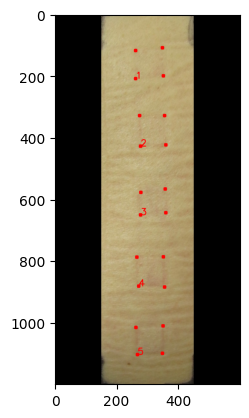

In [95]:
img_path = new_dst / imgn

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, img_size_15)

bbox_img = show_pnts_with_text(img, pnts)

plt.imshow(bbox_img)

In [99]:
ori_anno_root = Path("/workspace/datasets/seg_by_patient/anno")

ac_prefix = "all_complete_"
ori_train_path = ori_anno_root / f"{ac_prefix}train.json"
ori_test_path = ori_anno_root / f"{ac_prefix}test.json"

ori_train = load_json(ori_train_path)
ori_test = load_json(ori_test_path)

pre_ac_anno_root = Path("/workspace/datasets/seg_by_patient/preprocessed/anno")
pre_ac_anno_path = pre_ac_anno_root / "pre_all_complete_merge.json"

pre_ac_anno = load_json(pre_ac_anno_path)

pre_ac_train = {k:pre_ac_anno[k] for k in ori_train}
pre_ac_test = {k:pre_ac_anno[k] for k in ori_test}

print("Train")
print("ori_train:", len(ori_train))
print("pre_ac_train:", len(pre_ac_train))

print("Test")
print("ori_test:", len(ori_test))
print("pre_ac_test:", len(pre_ac_test))

dst_pac_train = pre_ac_anno_root / "pre_all_complete_train.json"
dst_pac_test = pre_ac_anno_root / "pre_all_complete_test.json"

save2json(pre_ac_train, dst_pac_train)
save2json(pre_ac_test, dst_pac_test)


Train
ori_train: 183
pre_ac_train: 183
Test
ori_test: 69
pre_ac_test: 69
Writing json file..................................................
Done! Json was wrote to /workspace/datasets/seg_by_patient/preprocessed/anno/pre_all_complete_train.json
Writing json file..................................................
Done! Json was wrote to /workspace/datasets/seg_by_patient/preprocessed/anno/pre_all_complete_test.json


In [38]:
clss = [
    {"id":0, "name": "level_0"},
    {"id":1, "name": "level_1"},
    {"id":2, "name": "level_2"},
    {"id":3, "name": "level_3"},
    {"id":4, "name": "level_4"},
]

cls_dict = {
    0: [0, "level_0"],
    1: [1, "level_1"],
    2: [2, "level_2"],
    3: [3, "level_3"],
    4: [4, "level_4"],
}

pre_ac_root = Path("/workspace/datasets/seg_by_patient/preprocessed/anno")
pre_ac_train = pre_ac_root / "pre_all_complete_train.json"
pre_ac_test = pre_ac_root / "pre_all_complete_test.json"
pre_ac_all = pre_ac_root / "pre_all_complete_merge.json"

coco_dst_all = coco_dst / "all_complete_merge.json"
coco_dst = Path("/workspace/datasets/seg_by_patient/preprocessed/anno/coco_format")
coco_dst_train = coco_dst / "pre_all_complete_train.json"
coco_dst_test = coco_dst / "pre_all_complete_test.json"
coco_dst_all = coco_dst / "pre_all_complete_merge.json"

img_root = "/workspace/datasets/seg_by_patient/preprocessed/pos_cropped_patch_all_r1_r2"
# img_root = "/workspace/datasets/skin_patch_img_dataset/cropped_patch_all_r1_r2"


coco_train_anno = convert2coco(pre_ac_train, img_root, coco_dst_train, clss, cls_dict)
coco_test_anno = convert2coco(pre_ac_test, img_root, coco_dst_test, clss, cls_dict)
coco_all_anno = convert2coco(pre_ac_all, img_root, coco_dst_all, clss, cls_dict)


100%|██████████| 183/183 [00:00<00:00, 287.04it/s]


Writing json file..................................................
Done! Json was wrote to /workspace/datasets/seg_by_patient/preprocessed/anno/coco_format/pre_all_complete_train.json


100%|██████████| 69/69 [00:00<00:00, 494.56it/s]


Writing json file..................................................
Done! Json was wrote to /workspace/datasets/seg_by_patient/preprocessed/anno/coco_format/pre_all_complete_test.json


100%|██████████| 274/274 [00:00<00:00, 474.41it/s]

Writing json file..................................................
Done! Json was wrote to /workspace/datasets/seg_by_patient/preprocessed/anno/coco_format/pre_all_complete_merge.json


In [33]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

# coco_anno_root = "/workspace/datasets/seg_by_patient/preprocessed/anno/coco_format/"
# all_anno = os.path.join(coco_anno_root, "pre_all_complete_merge.json")
# train_anno = os.path.join(coco_anno_root, "pre_all_complete_train.json")
# test_anno = os.path.join(coco_anno_root, "pre_all_complete_test.json")

coco_anno_root = "/workspace/datasets/seg_by_patient/anno/coco_format/"
all_anno = os.path.join(coco_anno_root, "all_complete_merge.json")
train_anno = os.path.join(coco_anno_root, "all_complete_train.json")
test_anno = os.path.join(coco_anno_root, "all_complete_test.json")

# from detectron2.data import DatasetCatalog, MetadataCatalog

# train_dicts = DatasetCatalog.get("train_ds")

# print(train_dicts[0])

DatasetCatalog.remove("train_ds")
MetadataCatalog.remove("train_ds")

DatasetCatalog.remove("test_ds")
MetadataCatalog.remove("test_ds")

DatasetCatalog.remove("all_ds")
MetadataCatalog.remove("all_ds")

register_coco_instances("train_ds", {}, train_anno, img_root)
register_coco_instances("test_ds", {}, test_anno, img_root)
register_coco_instances("all_ds", {}, all_anno, img_root)

# register_coco_instances("train_ds", {}, str(coco_dst_train), img_root)
# register_coco_instances("test_ds", {}, str(coco_dst_test), img_root)
# register_coco_instances("all_ds", {}, str(coco_dst_all), img_root)

train_dicts = DatasetCatalog.get("train_ds")
test_dicts = DatasetCatalog.get("test_ds")
all_dicts = DatasetCatalog.get("all_ds")


print(train_dicts[0])


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.




Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



{'file_name': '/workspace/datasets/skin_patch_img_dataset/cropped_patch_all_r1_r2/raw1_01.D2(30m)-1.JPG', 'height': 1236, 'width': 594, 'image_id': 0, 'annotations': [{'bbox': [103, 105, 110, 110], 'category_id': 0, 'segmentation': [[106.25926208496094, 115.68518829345703, 207.1851806640625, 115.68518829345703, 210.88888549804688, 202.72222900390625, 109.96295928955078, 205.5]], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'bbox': [282, 25, 92, 91], 'category_id': 0, 'segmentation': [[290.5185241699219, 32.35185241699219, 371.0740661621094, 32.35185241699219, 371.0740661621094, 108.27777862548828, 285.8888854980469, 110.12963104248047]], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'bbox': [431, 116, 91, 90], 'category_id': 0, 'segmentation': [[444.22222900390625, 119.38888549804688, 514.5925903320312, 124.01851654052734, 514.5925903320312, 203.6481475830078, 439.59259033203125, 192.5370330810547]], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'bbox': [420, 331, 104, 104], 'category_id': 0, 'segmentation':

In [8]:
import json, os
from collections import Counter

JSON_PATH = all_anno
IM_ROOT   = img_root  # optional, for existence checks

def to_int(x):
    # Coerce "123" -> 123; leave int as-is
    if isinstance(x, str) and x.isdigit():
        return int(x)
    if isinstance(x, (int,)):
        return x
    # try best-effort conversion
    try:
        return int(x)
    except Exception:
        return x

with open(JSON_PATH, "r") as f:
    coco = json.load(f)

images = coco.get("images", [])
anns   = coco.get("annotations", [])
cats   = coco.get("categories", [])

# Build maps
img_id_to_file = {}
img_ids = []
for im in images:
    iid = to_int(im["id"])
    img_id_to_file[iid] = im.get("file_name", f"<no filename for id {iid}>")
    img_ids.append(iid)

img_id_set = set(img_ids)

# 1) List duplicate image ids (also a common cause)
dups = [k for k,v in Counter(img_ids).items() if v>1]
if dups:
    print("❌ Duplicate image ids:", dups)

# 2) Find orphans
orphans = []
bad_type = []
for a in anns:
    ann_id = a.get("id", "<no ann id>")
    iid_raw = a.get("image_id")
    iid = to_int(iid_raw)
    if not isinstance(iid, int):
        bad_type.append((ann_id, iid_raw))
        continue
    if iid not in img_id_set:
        orphans.append((ann_id, iid, img_id_to_file.get(iid, "<missing image>")))

print(f"Images: {len(images)}  Annotations: {len(anns)}")
print(f"Orphan annotations: {len(orphans)}")
if orphans:
    # show a few
    for tup in orphans[:20]:
        print("  ann_id:", tup[0], " image_id:", tup[1], " → filename:", tup[2])

if bad_type:
    print("\n⚠️ Non-numeric image_id found (type mismatch). First few:")
    for ann_id, raw in bad_type[:10]:
        print("  ann_id:", ann_id, " image_id(raw):", raw, " type:", type(raw))

# 3) Optional: check files exist on disk
missing_files = [fn for fn in img_id_to_file.values()
                 if fn and IM_ROOT and not os.path.exists(os.path.join(IM_ROOT, fn))]
if missing_files:
    print("\n⚠️ Missing files on disk (first few):")
    for fn in missing_files[:20]:
        print(" ", fn)


Images: 274  Annotations: 3360
Orphan annotations: 5
  ann_id: 3355  image_id: 274  → filename: <missing image>
  ann_id: 3356  image_id: 274  → filename: <missing image>
  ann_id: 3357  image_id: 274  → filename: <missing image>
  ann_id: 3358  image_id: 274  → filename: <missing image>
  ann_id: 3359  image_id: 274  → filename: <missing image>


In [12]:
aa = load_json(all_anno)

imgs = aa["images"]
anns = aa["annotations"]

In [13]:
anns[3355]

{'id': 3355,
 'image_id': 274,
 'category_id': 1,
 'segmentation': [[109.21428680419922,
   94.44642639160156,
   252.9642791748047,
   90.875,
   254.75,
   198.01785278320312,
   110.10713958740234,
   199.80357360839844]],
 'bbox': [106, 69, 151, 152],
 'is_crowd': 0}

In [14]:
len(imgs)

274

In [15]:
imgs[-1]

{'id': 273, 'file_name': 'raw2_33.D2(30m)-4.JPG', 'width': 372, 'height': 1188}